<a href="https://colab.research.google.com/github/JuneSHYoo/monitory-ml/blob/main/Retraining_pip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install boto3

In [ ]:
#### S3 데이터 불러오기
import boto3
import json
import pandas as pd


from google.colab import userdata

access_key = userdata.get('AWS_ACCESS_KEY_ID')
secret_key = userdata.get('AWS_SECRET_ACCESS_KEY')

s3 = boto3.client(
    's3',
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key,
    region_name='ap-northeast-2'
)

In [ ]:
DATA_BUCKET = "monitory-bucket"          # 원본 버킷
ROOT_PREFIX = "EQUIPMENT/"               # 항상 슬래시(/)로 끝나도록

# 🔍 (옵션) 특정 월만 가져오고 싶다면:
TARGET_MONTH = "2025-06"  # YYYY-MM
prefix_filter = f"{ROOT_PREFIX}date={TARGET_MONTH}-"

s3 = boto3.client(
    's3',
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key,
    region_name='ap-northeast-2'
)


def list_keys(prefix):
    """prefix에 매칭되는 모든 json object key 반환 (폴더 개념 X)"""
    paginator = s3.get_paginator("list_objects_v2")
    for page in paginator.paginate(Bucket=DATA_BUCKET, Prefix=prefix):
        for obj in page.get("Contents", []):
            if obj["Key"].endswith(".json"):
                yield obj["Key"]

keys = list(list_keys(prefix_filter))
print(f"💡 총 {len(keys):,}개 json 파일 발견")

💡 총 190개 json 파일 발견


In [ ]:
import io, pandas as pd
from tqdm.auto import tqdm
# ──────────────────────────
# json ➜ DataFrame 로딩
#  • 파일당 1~1.5 MB → 수천 개여도 Colab RAM(여유) 가능
#  • 아주 크면 ① chunk / ② Dask / ③ AWS Athena / ④ AWS Data Wrangler 추천
# ──────────────────────────
def load_ndjson_from_keys(keys, sample_n=None):
    dfs = []
    iterable = keys if sample_n is None else keys[:sample_n]
    for key in tqdm(iterable, desc="🚀 NDJSON load"):
        body = s3.get_object(Bucket=DATA_BUCKET, Key=key)['Body'].read()
        df   = pd.read_json(io.BytesIO(body), lines=True)   # 핵심!
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df_raw = load_ndjson_from_keys(keys)   # sample_n=500 로 부분 로딩 가능
print(df_raw.shape)
df_raw.head()

🚀 NDJSON load:   0%|          | 0/190 [00:00<?, ?it/s]

(232786, 8)


,zoneId,equipId,sensorId,sensorType,val,category,time,faulty
0,20250507165750-827,20250507171316-389,UA10P-PWR-24060890,reactive_power,26506.42,EQUIPMENT,2025-06-02T17:49:02.439000,0.0
1,20250507165750-827,20250507171316-389,UA10P-PWR-24060890,active_power,42426.60,EQUIPMENT,2025-06-02T17:49:02.440000,0.0
2,20250507165750-827,20250507171316-389,UA10P-PWR-24060890,active_power,42630.42,EQUIPMENT,2025-06-02T17:49:07.469000,0.0
3,20250507165750-827,20250507171316-389,UA10P-PWR-24060890,reactive_power,27543.84,EQUIPMENT,2025-06-02T17:49:07.469000,0.0
4,20250507165750-827,20250507171316-389,UA10P-PWR-24060890,reactive_power,29046.32,EQUIPMENT,2025-06-02T17:49:12.456000,0.0


In [ ]:
sample_key = keys[0]
body = s3.get_object(Bucket=DATA_BUCKET, Key=sample_key)['Body'].read().decode()[:300]
print("--- first 300 chars ---\n", body)

--- first 300 chars ---
 {"zoneId":"20250507165750-827","equipId":"20250507171316-389","sensorId":"UA10P-PWR-24060890","sensorType":"reactive_power","val":26506.42,"category":"EQUIPMENT","time":"2025-06-02T17:49:02.439000","faulty":0}
{"zoneId":"20250507165750-827","equipId":"20250507171316-389","sensorId":"UA10P-PWR-240608


In [ ]:
import numpy as np

In [ ]:
import pandas as pd
import pytz   # 표준 라이브러리 zoneinfo(3.9+) 를 써도 됨

df = df_raw.copy()

# 0) 타임스탬프 파싱 → UTC 로 먼저 tz-aware
df["timestamp"] = pd.to_datetime(df["time"], utc=True)
df.drop(columns = ['time','zoneId', 'sensorId'], inplace=True)

In [ ]:
# 2) 사용할 센서만 필터
keep_sensors = [
    "active_power", "humid", "pressure",
    "reactive_power", "temp", "vibration"
]
df_use = df[df["sensorType"].isin(keep_sensors)].copy()

In [ ]:
df_use.sensorType.unique()

array(['reactive_power', 'active_power', 'vibration', 'humid', 'temp',
       'pressure'], dtype=object)

In [ ]:
# 3) KST 기준 1 시간 버킷으로 내림(floor)
df_use["ts_hour"] = df_use["timestamp"].dt.floor("H")

<ipython-input-11-2227822634>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_use["ts_hour"] = df_use["timestamp"].dt.floor("H")


In [ ]:
# 4) 피벗(장비·존·시간 단위) + 평균
df_wide = (
    df_use.pivot_table(
        index=["ts_hour", "equipId"],
        columns="sensorType",
        values="val",
        aggfunc="max",
    )
    .reset_index()
    .rename(columns={"ts_hour": "timestamp"})   # 최종 열 이름을 'timestamp' 로
)
df_wide.columns

Index(['timestamp', 'equipId', 'active_power', 'humid', 'pressure',
       'reactive_power', 'temp', 'vibration'],
      dtype='object', name='sensorType')

In [ ]:
# 4. 결측 보정 & rolling feature
num_cols = ['temp','pressure','vibration','humid',
            'active_power','reactive_power']

for col in num_cols:
    grp = df_wide.groupby("equipId")[col]
    df_wide[f"{col}_rollmean"] = (
        grp.rolling(window=5, min_periods=1)
           .mean().reset_index(level=0, drop=True)
    )
    df_wide[f"{col}_rollstd"] = (
        grp.rolling(window=5, min_periods=1)
           .std().reset_index(level=0, drop=True).fillna(0)
    )

df_wide["power_factor"] = (
    df_wide["active_power"] /
    np.sqrt(df_wide["active_power"]**2 + df_wide["reactive_power"]**2)
).fillna(0)

In [ ]:
import numpy as np

# 0) 분류
raw_cols   = ["active_power","reactive_power",
              "temp","pressure","vibration","humid"]
roll_std   = [c for c in df_wide.columns if c.endswith("_rollstd")]
roll_mean  = [c for c in df_wide.columns if c.endswith("_rollmean")]

# 1) 설비별 시간 정렬
df_wide = df_wide.sort_values(["equipId","timestamp"])

# 2) forward / backward fill  (작은 결측만)
df_wide[raw_cols] = (
    df_wide.groupby("equipId")[raw_cols]
           .ffill(limit=3)      # 직전 ≤3 시간
           .bfill(limit=1)      # 직후 1 시간
)

# 3) 남은 NaN → 중앙값
for col in raw_cols:
    median = df_wide[col].median()
    df_wide[col].fillna(median, inplace=True)

# 4) 롤링 표준편차는 0으로
df_wide[roll_std] = df_wide[roll_std].fillna(0)

# 5) 롤링 평균: 원본 센서 보간 후 다시 계산 (간단히 ffill 도 가능)
# 예시) temperature_rollmean 재계산
win = 6
for col in ["temp","pressure","vibration","humid",
            "active_power","reactive_power"]:
    grp = df_wide.groupby("equipId")[col]
    df_wide[f"{col}_rollmean"] = (
        grp.rolling(win,min_periods=1).mean()
           .reset_index(level=0,drop=True)
    )

# 6) 행 단위 결측률 기준으로 drop
row_nan_ratio = df_wide[raw_cols].isna().mean(axis=1)
df_wide = df_wide[row_nan_ratio < 0.5]

print(df_wide.isna().sum())

sensorType
timestamp                  0
equipId                    0
active_power               0
humid                      0
pressure                   0
reactive_power             0
temp                       0
vibration                  0
temp_rollmean              0
temp_rollstd               0
pressure_rollmean          0
pressure_rollstd           0
vibration_rollmean         0
vibration_rollstd          0
humid_rollmean             0
humid_rollstd              0
active_power_rollmean      0
active_power_rollstd       0
reactive_power_rollmean    0
reactive_power_rollstd     0
power_factor               0
dtype: int64


<ipython-input-14-1263194036>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_wide[col].fillna(median, inplace=True)


### RUL 계산하기

In [ ]:
############################
## 센서별 alert 임계치 딕셔너리 #
############################

ALERT_THRESH = {
    "temperature":    (41, 101),      # °C
    "pressure":       (4.6, 66.88),   # bar
    "vibration":      (-0.5, 3.80),   # g(rms)
    "humidity":       (14.5, 85.54),  # %RH
    "active_power":   (0, 168_026),   # W
    "reactive_power": (0, 86_759),    # var
}

import numpy as np
import pandas as pd

# (1) 초기값 0
df_use["alert"] = 0

# (2) 센서별로 하·상한 조건 OR
for sensor, (lo, hi) in ALERT_THRESH.items():
    mask_sensor = df_use["sensorType"] == sensor
    vals        = df_use.loc[mask_sensor, "val"]
    alert_mask  = (vals < lo) | (vals > hi)
    df_use.loc[mask_sensor, "alert"] = alert_mask.astype("int8")

# (3) 1시간 버킷 ts_hour 단위 고장 집계
K, M, N = 2, 3, 2   # 예시 (동시 2센서·3버킷 연속·쿨다운 2h)

faulty_tmp = (
    df_use.groupby(["ts_hour", "equipId"])["alert"]
          .sum()
          .reset_index(name="alert_cnt")
)
faulty_tmp["faulty_tmp"] = (faulty_tmp["alert_cnt"] >= K).astype(int)


In [ ]:
############################
### df_wide에 RUL 계산하기  ###
############################

############################################
# 1) 키 맞추기 & merge
############################################
faulty_hour = (
    faulty_tmp
      .rename(columns={"ts_hour": "timestamp", "faulty_tmp":'faulty'})      # ⇒ df_wide 와 동일 키
      [["timestamp",  "equipId", "faulty"]]
)

df_wide = (
    df_wide.merge(faulty_hour,
                  on=["timestamp",  "equipId"],
                  how="left")
            .fillna({"faulty": 0})
            .astype({"faulty": "int8"})
)

############################################
# 2) 설비별 RUL(step) 계산
############################################
def add_rul(group: pd.DataFrame) -> pd.DataFrame:
    n   = len(group)
    rul = np.full(n, np.nan, dtype=np.float32)

    nxt = None                       # 다음 고장까지 남은 스텝
    for i in range(n - 1, -1, -1):   # 뒤 → 앞
        if group.iloc[i]["faulty"] == 1:
            nxt = 0
        else:
            nxt = (nxt + 1) if nxt is not None else np.nan
        rul[i] = nxt
    group["RUL_step"] = rul
    return group

df_wide = (
    df_wide.sort_values(["equipId", "timestamp"])    # 시간 정렬
           .groupby("equipId", group_keys=False)
           .apply(add_rul)
)

############################################
# 3) RUL Step NaN 채우기
############################################

MAX_RUL = 30   # 30일 (= 720h) 예시

# 1) 아직 고장 전 구간  →  최대치로 채우기
df_wide["RUL_step"] = df_wide["RUL_step"].fillna(MAX_RUL).clip(upper=MAX_RUL)
df_wide = df_wide.rename(columns = {'RUL_step':'rul'})

<ipython-input-17-1888787453>:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(add_rul)


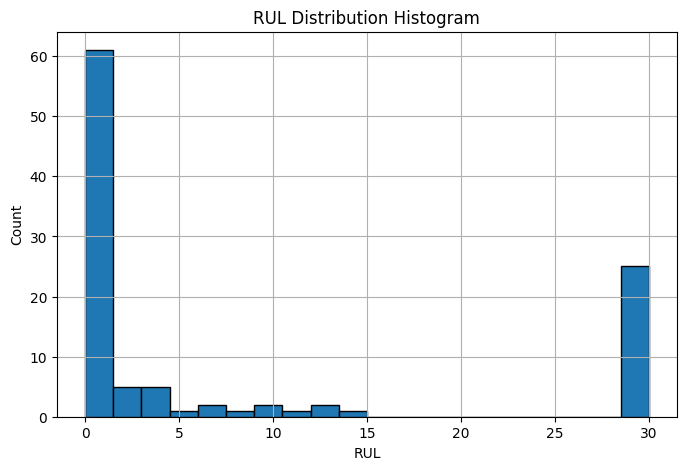

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_wide["rul"], bins=20, edgecolor='black')  # bins 개수는 데이터에 따라 조절 가능
plt.title('RUL Distribution Histogram')
plt.xlabel('RUL')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:
#######################################################################
# 0.  사전 환경 : df_wide  ←  RUL_step 계산까지 끝난 DataFrame
#                 (timestamp, zoneId, equipId, …, faulty, RUL_step)
#######################################################################

import pandas as pd, numpy as np, lightgbm as lgb, boto3, json, datetime, io
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

############################################################################
# 1. 다운샘플(0), 오버샘플(1–15)
############################################################################
DOWN_RATIO_ZERO = 0.2          # 0 → 20%만 유지
OVER_RATIO      = {            # 1-15 구간 배수(예시)
    1:  3,  2: 8,  3: 8,
    4:  10,  5: 10,
    6:  12,  7: 16,  8: 17,  9: 19,
   10: 20, 11:20, 12:20, 13:20, 14:20, 15:20
}

df = df_wide.copy()

# (1) 0 구간 다운샘플
zero_df   = df[df.rul == 0]
keep_n    = int(len(zero_df) * DOWN_RATIO_ZERO)
zero_df   = zero_df.sample(keep_n, random_state=42)

# (2) 1–15 구간 오버샘플
dfs = [zero_df]
for k, v in OVER_RATIO.items():
    tmp = df[df.rul == k]
    if not tmp.empty:
        dfs.append(pd.concat([tmp] * v, ignore_index=True))

balanced_df = pd.concat(dfs, ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42)   # 셔플

In [ ]:

balanced_df = balanced_df.rename(columns = {'equipment':'equipId'})

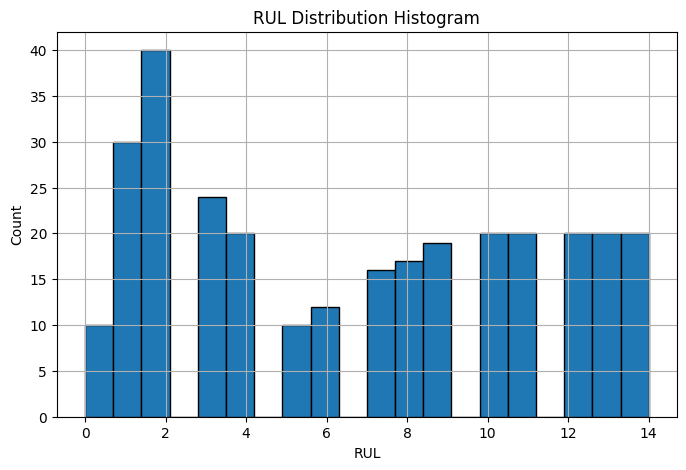

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(balanced_df["rul"], bins=20, edgecolor='black')  # bins 개수는 데이터에 따라 조절 가능
plt.title('RUL Distribution Histogram')
plt.xlabel('RUL')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [ ]:

############################################################################
# 2. 피처 · 타깃 설정
############################################################################
feature_cols = [
    'temp','pressure','vibration','humid',
    'active_power','reactive_power',
    'active_power_rollmean','active_power_rollstd',
    'reactive_power_rollmean','reactive_power_rollstd',
    'power_factor',
    'temp_rollmean','temp_rollstd',
    'pressure_rollmean','pressure_rollstd',
    'vibration_rollmean','vibration_rollstd',
    'humid_rollmean','humid_rollstd',
    'equipId'                    # 카테고리
]
target_col = 'rul'

balanced_df['equipId'] = balanced_df['equipId'].astype('category')


X = balanced_df[feature_cols]
X = X.rename(columns={'equipId': 'equipment'})
y = balanced_df[target_col]

############################################################################
# 3. train / valid / test = 60 / 20 / 20
############################################################################
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
# → (0.25 of 0.8) = 0.20

############################################################################
# 4. LightGBM 재학습
############################################################################
model = lgb.LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    num_leaves=64,
    objective='regression',
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_names=['train','valid'],
    eval_metric='rmse',
    categorical_feature=['equipment'],
    callbacks=[
        lgb.log_evaluation(period=50),
        lgb.early_stopping(stopping_rounds=50)
    ]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 19
[LightGBM] [Info] Start training from score 6.038462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

LGBMRegressor(learning_rate=0.05, n_estimators=600, num_leaves=64,
              objective='regression', random_state=42)

In [ ]:
# 추가: evals_result_로 로그 직접 저장 (LightGBM v3 이상)
evals_result = model.evals_result_
print(evals_result)

# 예측 및 성능 확인
y_pred = model.predict(X_test)
# y_pred = np.expm1(y_pred_log)  # 원래 스케일로 역변환
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"RMSE: {mse**0.5:.2f} | MAE: {mae:.2f} | R2: {r2:.4f}")


{'train': OrderedDict([('rmse', [np.float64(4.49228517758086), np.float64(4.384362722928738), np.float64(4.284629603133518), np.float64(4.192584202643572), np.float64(4.092724017449787), np.float64(4.013139106984158), np.float64(3.925479543592498), np.float64(3.8566827266652592), np.float64(3.780040065060543), np.float64(3.7090185117485546), np.float64(3.653766294630128), np.float64(3.590027273759054), np.float64(3.5303968057091977), np.float64(3.484834053436817), np.float64(3.4298718721760175), np.float64(3.38973010329846), np.float64(3.340761568807415), np.float64(3.295062180680066), np.float64(3.2515424895410665), np.float64(3.2136276036779137), np.float64(3.1790212318412703), np.float64(3.1411741033979568), np.float64(3.110509430950518), np.float64(3.0825726936444298), np.float64(3.049586394397372), np.float64(3.017482307851911), np.float64(2.9942159057559747), np.float64(2.9656396521496027), np.float64(2.945133716251664), np.float64(2.9265037579689315), np.float64(2.90145080251401

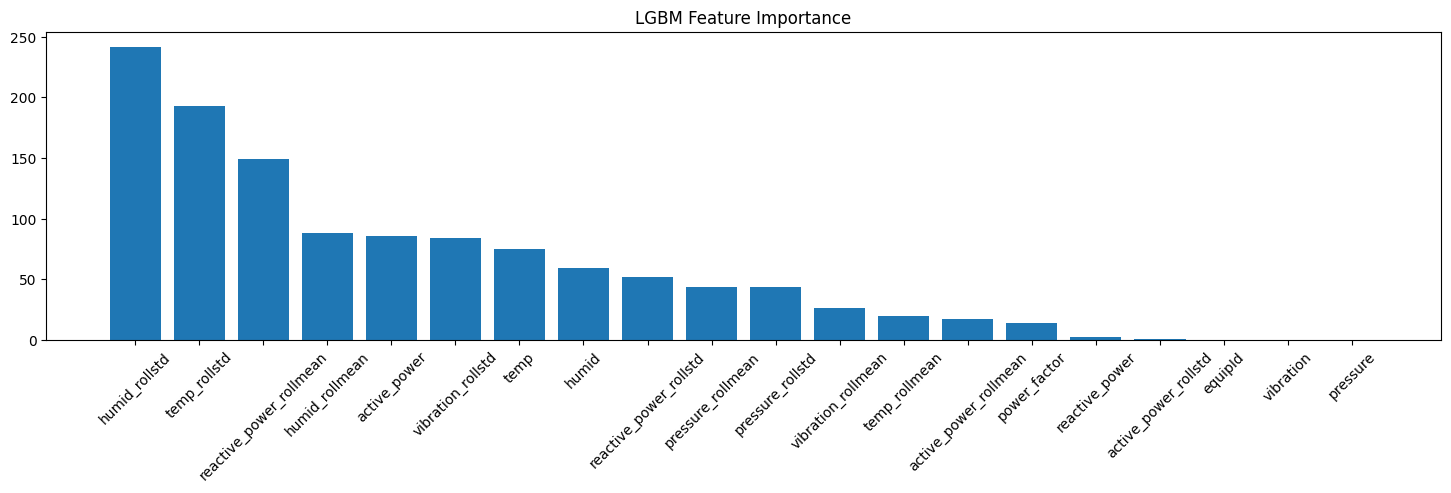

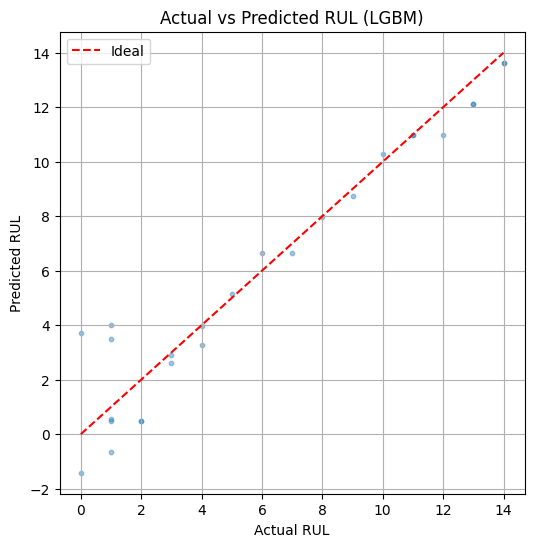

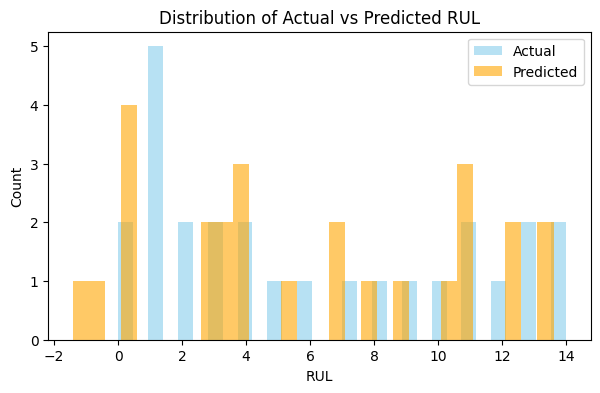

In [ ]:
# Feature Importance
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(18,4))
sorted_idx = np.argsort(model.feature_importances_)[::-1]
plt.bar(np.array(feature_cols)[sorted_idx], model.feature_importances_[sorted_idx])
plt.xticks(rotation=45)
plt.title('LGBM Feature Importance')
plt.show()

###

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, s=10, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal')  # 대각선
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL (LGBM)")
plt.legend()
plt.grid(True)
plt.show()

###


plt.figure(figsize=(7, 4))
plt.hist(y_test, bins=30, alpha=0.6, label='Actual', color='skyblue')
plt.hist(y_pred, bins=30, alpha=0.6, label='Predicted', color='orange')
plt.xlabel("RUL")
plt.ylabel("Count")
plt.title("Distribution of Actual vs Predicted RUL")
plt.legend()
plt.show()

In [ ]:
#######################
## 메트릭 및 모델 저장하기
#######################

## new 모델 메트릭 계산

y_pred = model.predict(X_test)
# y_pred = np.expm1(y_pred_log)  # 원래 스케일로 역변환
mse   = mean_squared_error(y_test, y_pred)
rmse  = mse**0.5
mae   = mean_absolute_error(y_test, y_pred)
r2    = r2_score(y_test, y_pred)
print(f"RMSE: {mse**0.5:.2f} | MAE: {mae:.2f} | R2: {r2:.4f}")

RMSE: 1.29 | MAE: 0.88 | R2: 0.9275


In [ ]:
#######################
## S3 비교, 업로드 로직
#######################

BUCKET      = "monitory-model"
UTC_NOW     = datetime.datetime.utcnow()
MODEL_SAVE_KEY     = UTC_NOW.strftime("models/%Y/%m/%d/%H%M%S/lgbm_regressor.json")
METRIC_SAVE_KEU  = UTC_NOW.strftime("models/%Y/%m/%d/%H%M%S/metrics.json")
LATEST_KEY  = "models/latest/lgbm_regressor.json"
METRIC_KEY  = "models/latest/metrics.json"

# 새 모델 dict
model_dict = model.booster_.dump_model()
new_meta   = {"date": UTC_NOW.isoformat()[:19]+"Z",
              "rmse": rmse, "mae": mae, "r2": r2, "ver_key": VER_KEY}

access_key = userdata.get('AWS_ACCESS_KEY_ID')
secret_key = userdata.get('AWS_SECRET_ACCESS_KEY')

s3 = boto3.client(
    's3',
    aws_access_key_id=access_key,
    aws_secret_access_key=secret_key,
    region_name='ap-northeast-2'
)

# 기준 메트릭 로드 (없으면 +∞)
try:
    old_meta = json.loads(s3.get_object(Bucket=BUCKET, Key=METRIC_KEY)['Body'].read())
    old_rmse = old_meta['rmse']

except s3.exceptions.NoSuchKey:
    old_rmse = float("inf")


# 승격 여부 판단
promote = rmse < old_rmse
print("▲ 승격" if promote else "▼ 유지")


# 히스토리 버전은 항상 저장
s3.put_object(Bucket=BUCKET, Key=MODEL_SAVE_KEY,
              Body=json.dumps(model_dict).encode())
s3.put_object(Bucket=BUCKET, Key=METRIC_SAVE_KEU,
              Body=json.dumps(new_meta, indent=2).encode())


# 승격이면 latest 갱신
if promote:
    s3.put_object(Bucket=BUCKET, Key=LATEST_KEY,
                  Body=json.dumps(model_dict).encode())
    s3.put_object(Bucket=BUCKET, Key=METRIC_KEY,
                  Body=json.dumps(new_meta, indent=2).encode())

▼ 유지
